# Preprocessing

## Import necessary packages

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import zipfile
import pickle
import torch
import time
import h5py
import cv2
import os

In [2]:
def is_zip(dir):
    return dir.endswith(".zip")

In [3]:
zip_root_dir = 'data/'
data_root_dir = 'data_dump/'
new_data_dir = 'dataset/'

if not os.path.exists(data_root_dir):
    os.mkdir(data_root_dir)

zip_files = list(filter(is_zip, os.listdir(zip_root_dir)))

for i, zip_file in enumerate(zip_files):
    dir = zip_root_dir + zip_file
    with zipfile.ZipFile(dir) as f:
        f.extractall(f'{data_root_dir}/bt_{i}')

One .mat file is made up of the following:

- A PID
- An image
- A label (between 1 and 3, tumor type)
- A tumorBorder (coordinates)
- A tumorMask (image with only the tumor border)

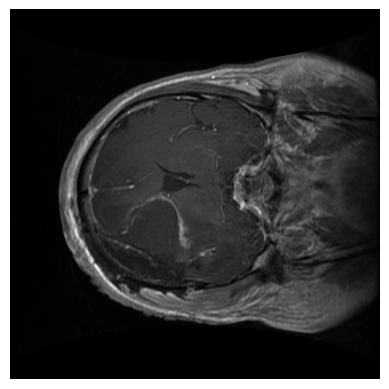

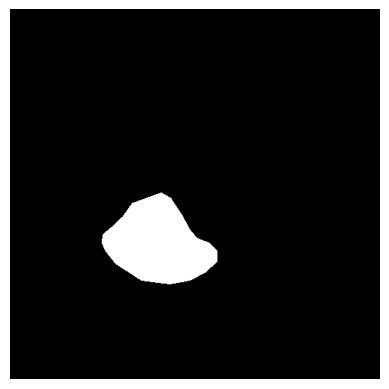

In [4]:
with h5py.File(f'{data_root_dir}/bt_0/2299.mat', 'r') as f:
    img = f['cjdata']['image']
    mask = f['cjdata']['tumorMask']
    img = np.array(img, dtype=np.float32)
    img = img/127.5 - 1
    mask = np.array(mask, dtype=np.float32)
    mask = mask/127.5 - 1
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    fig = plt.figure(3)
    plt.axis('off')
    plt.imshow(mask, cmap='gray')

Saved 3064 files


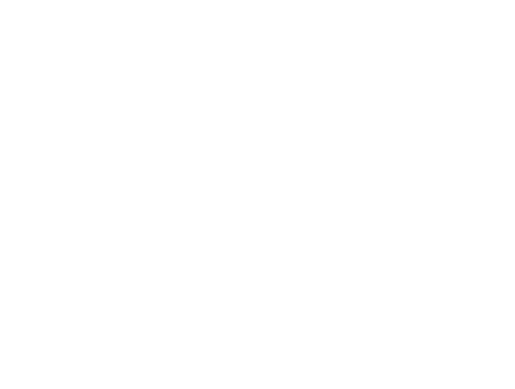

In [5]:
# Create new dataset to store only the attributes we care about
if not os.path.exists(new_data_dir):
    os.mkdir(new_data_dir)
    os.mkdir(f'{new_data_dir}/tumor_images') # Create folder for images of brain tumors
    os.mkdir(f'{new_data_dir}/tumor_masks') # Create folder for images of brain tumor masks

labels = []
file_count = 0

for subdir, dirs, files in os.walk(data_root_dir):
    for file in files:
        with h5py.File(f'{subdir}/{file}', 'r') as f:
            img = f['cjdata']['image']
            label = f['cjdata']['label'][0][0]

            labels.append(int(label))
            img = np.array(img, dtype=np.float32)
            plt.axis('off')
            plt.imsave(f'{new_data_dir}/tumor_images/{file_count}.jpg', img, cmap='gray')
            file_count += 1

print(f'Saved {file_count} files')

In [6]:
label_names = np.array(labels, dtype=np.int64)

with open(f"{new_data_dir}/labels.pickle","wb") as output:
    pickle.dump(label_names, output)

In [7]:
train = []
file_count = 0

for subdir, dirs, files in os.walk(new_data_dir):
    for file in files:
        if file.endswith('.jpg'):
            file = f'{subdir}/{file}'
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Convert grayscale image to RGB
            img = cv2.resize(img, (512, 512))
            label = label_names[file_count]
            train.append([img, label])
            file_count += 1

print(f'{file_count} samples successfully preprocessed')

with open(f"{new_data_dir}/train.pickle", "wb") as output:
    pickle.dump(train, output)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

3064 samples successfully preprocessed


In [8]:
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, is_training=False):
        self.X = images
        self.y = labels
        self.is_training = is_training
        self.transforms_dict = self._get_transforms()

    def _get_transforms(self):
        transforms_dict = {}
        
        # Base transformation that applies to all images
        common_transforms = [
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ]
        transforms_dict['base'] = transforms.Compose(common_transforms)
        
        # Transformations that are only applied if the model is training
        if self.is_training:
            # Rotation
            for angle in [45, 90, 120, 180, 270, 300, 330]:
                transforms_dict[f'rot_{angle}'] = transforms.RandomRotation(angle)
            
        return transforms_dict


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        images = self.get_images(idx) 

        labels = torch.zeros(4, dtype=torch.float32)
        labels[int(self.y[idx])] = 1.0

        new_labels = [labels, labels, labels, labels, labels, labels, labels, labels]

        return (torch.stack(new_labels), torch.stack(images)) # Stack labels and images

    
    def get_images(self, idx):
        transformed_images = []
        base_img = self.transforms_dict['base'](self.X[idx])  # Apply base transform

        transformed_images.append(base_img)

        # If model is in training mode, apply all available transformations
        if self.is_training:
            for transform_key in list(self.transforms_dict.keys())[1:]:  # Skip the first 'base' key
                transformed_img = self.transforms_dict[transform_key](base_img)
                transformed_images.append(transformed_img)

        return transformed_images



In [9]:
with open(f'{new_data_dir}/train.pickle', 'rb') as f:
    data = pickle.load(f)

X_set, y_set = zip(*data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.3, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_set, y_set, test_size=0.5, shuffle=True)

In [11]:
X_set = None
y_set = None

In [12]:
train =  BrainTumorDataset(X_train, y_train, is_training=True)
valid =  BrainTumorDataset(X_valid, y_valid, is_training=False)
test  =  BrainTumorDataset(X_test, y_test, is_training=False)

In [13]:
train_gen = DataLoader(train, batch_size=4, shuffle=True)
valid_gen = DataLoader(valid, batch_size=4, shuffle=True)
test_gen = DataLoader(test, batch_size=10, shuffle=True)

In [14]:
data, target = next(iter(train_gen))
print(f'Data shape = {data.shape}\nTarget shape = {target.shape}')

Data shape = torch.Size([4, 8, 4])
Target shape = torch.Size([4, 8, 3, 512, 512])


In [15]:
net = resnet50()

for param in net.parameters():
    param.requires_grad = True

n_inputs = net.fc.in_features

net.fc = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4),
)

for name, child in net.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True

net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(), momentum=0.9, lr=0.0001)
epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [17]:
def save_checkpoint(state, filename='bt_resnet18_ckpt.pth.tar'):
    torch.save(state, filename)

In [22]:
start_time_epoch = time.time()
best_validation_loss = 2
total_training_batches = len(train_gen)

training_losses, training_correct = [], []
validation_losses, validation_correct = [], []

for epoch_index in range(epochs):
    correct_train, correct_val = 0, 0
    epoch_start_time = time.time()

    with tqdm(total=total_training_batches, desc=f"# Epoch {epoch_index + 1}") as progress_bar:
        for batch_index, (labels, features) in enumerate(train_gen):
            reshaped_features = features.view(-1, 3, 512, 512)
            model_output = net(reshaped_features)

            target_labels = torch.argmax(labels.view(32, 4), dim=1).long()
            training_loss = criterion(model_output.float(), target_labels)

            predicted_labels = torch.argmax(model_output, dim=1).data
            correct_train += (predicted_labels == target_labels).sum()

            optim.zero_grad()
            training_loss.backward()
            optim.step()

            progress_bar.update(1)

        epoch_end_time = time.time()
        print(f'Epoch {epoch_index + 1}')
        print(f'Accuracy: {correct_train.item() * 100 / (32 * (batch_index + 1)):2.2f}%')
        print(f'Loss: {training_loss.item():2.4f}')
        print(f'Duration: {(epoch_end_time - epoch_start_time) / 60:.2f} minutes')

        training_losses.append(training_loss)
        training_correct.append(correct_train)

        with torch.no_grad():
            for val_batch_index, (val_labels, val_features) in enumerate(valid_gen):
                reshaped_val_features = val_features.view(-1, 3, 512, 512)
                val_model_output = net(reshaped_val_features)

                val_target_labels = torch.argmax(val_labels.view(32, 4), dim=1)
                correct_val += (torch.argmax(val_model_output, dim=1).data == val_target_labels).sum()

                batch_validation_loss = criterion(val_model_output.float(), val_target_labels.long())
                print(f'\rBatch Validation Loss: {batch_validation_loss.item():2.4f}', end='', flush=True)

        print()  # Move to next line after batch-wise validation loss

        final_validation_loss = criterion(val_model_output.float(), val_target_labels.long())
        print(f'Validation Accuracy {correct_val.item() * 100 / (32 * (val_batch_index + 1)):2.2f}% Final Validation Loss: {final_validation_loss.item():2.4f}')

        is_best = final_validation_loss < best_validation_loss
        best_validation_loss = min(final_validation_loss, best_validation_loss)


Epoch 1:   0%|          | 0/536 [00:02<?, ?it/s]


KeyboardInterrupt: 